In [35]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import warnings, gc
from featurewiz import featurewiz

In [36]:
train = pd.read_csv('/Users/naveenmsu/Desktop/Competition/DSU Competition Development Data.csv')
test = pd.read_csv('/Users/naveenmsu/Desktop/Competition/DSU Competition Out-Of-Time Data.csv')

In [24]:
target = 'Target'

In [25]:
def plot_roc(y_val,y_prob):
    colors=px.colors.qualitative.Prism
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Random Chance',mode='lines', showlegend=False,
                             line=dict(color="Black", width=1, dash="dot")))
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[::-1][i+1], width=3), 
                                 hovertemplate = 'True positive rate = %{y:.3f}<br>False positive rate = %{x:.3f}',
                                 name='Fold {}: AUC = {:.3f}'.format(i+1,roc_auc)))
    fig.update_layout(title="Cross-Validation ROC Curves", 
                      hovermode="x unified", width=700,height=600,
                      xaxis_title='False Positive Rate (1 - Specificity)',
                      yaxis_title='True Positive Rate (Sensitivity)',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()

In [26]:
# Utility function to perform one hot encoding
def encode_and_bind(originaldataframe, featuretoencode):
    originaldataframe[featuretoencode] = originaldataframe[featuretoencode].fillna('Missing')
    dummies = pd.get_dummies(originaldataframe[[featuretoencode]])
    res = pd.concat([originaldataframe, dummies], axis=1)
    #    print(res.columns)
    return(res)

# Main cleaning function
def transform_df(df):
#    Converting to Date datatype and splitting columns
    df['CurrentDate'] = pd.to_datetime(df['CurrentDate'], format = '%m/%d/%Y', errors = 'coerce')
    df['AccountDetail2'] = pd.to_datetime(df['AccountDetail2'], format = '%m/%d/%Y', errors = 'coerce')
    df['AccountStatus2'] = pd.to_datetime(df['AccountStatus2'], format = '%m/%d/%Y', errors = 'coerce')
    df['PrevAccountDetail1'] = pd.to_datetime(df['PrevAccountDetail1'], format = '%m/%d/%Y', errors = 'coerce')  
    df['AccountDetail8'] = pd.to_datetime(df['AccountDetail8'], format = '%m/%d/%Y', errors = 'coerce')
    df['Payment2'] = pd.to_datetime(df['Payment2'], format = '%m/%d/%Y', errors = 'coerce')
    df['Payment4'] = pd.to_datetime(df['Payment4'], format = '%m/%d/%Y', errors = 'coerce')
    
    # Imputing column values
    df['Payment2'].fillna(df['Payment4'])
    df['AccountStatus2'].fillna(df['AccountDetail8'])
    df['PrevAccountDetail1'].fillna(df['AccountDetail2'])
    
#     Splitting to month and year
    df['CurrentDateyear'] = df['CurrentDate'].dt.year
    df['CurrentDatemonth'] = df['CurrentDate'].dt.month
    df['AccountDetail2year'] = df['AccountDetail2'].dt.year
    df['AccountDetail2month'] = df['AccountDetail2'].dt.month
    df['AccountStatus2year'] = df['AccountStatus2'].dt.year
    df['AccountStatus2month'] = df['AccountStatus2'].dt.month
    df['PrevAccountDetail1year'] = df['PrevAccountDetail1'].dt.year
    df['PrevAccountDetail1month'] = df['PrevAccountDetail1'].dt.month
    df['AccountDetail8year'] = df['AccountDetail8'].dt.year
    df['AccountDetail8month'] = df['AccountDetail8'].dt.month
    df['Payment2year'] = df['Payment2'].dt.year
    df['Payment2month'] = df['Payment2'].dt.month
    df['Payment4year'] = df['Payment2'].dt.year
    df['Payment4month'] = df['Payment2'].dt.month
    
    # Label Encoding Columns
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    df['AccountDetail5'].fillna('NaN',inplace=True)
    df['AccountDetail6'].fillna('NaN',inplace=True)
    df['AccountDetail5cat'] = labelencoder.fit_transform(df['AccountDetail5'])
    df['AccountDetail6cat'] = labelencoder.fit_transform(df['AccountDetail6'])
    
    # Dropping Unnecessary columns
    df.drop(['CurrentDate','AccountDetail2',
             'AccountStatus2', 'PrevAccountDetail1',
             'AccountDetail8','Payment2','Payment4',
             'AccountDetail5',
             'AccountDetail6'],axis=1,inplace=True)
    
    
    return df

In [27]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
for col in ['AccountStatus1','PrevAccountStatus1','PrevAccountStatus2']:
    train[col] = enc.fit_transform(train[col])
    test[col] = enc.fit_transform(test[col])

In [28]:
train = transform_df(train)
test = transform_df(test)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (300000, 64)
#### Single_Label Binary_Classification problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (300000, 63)
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####

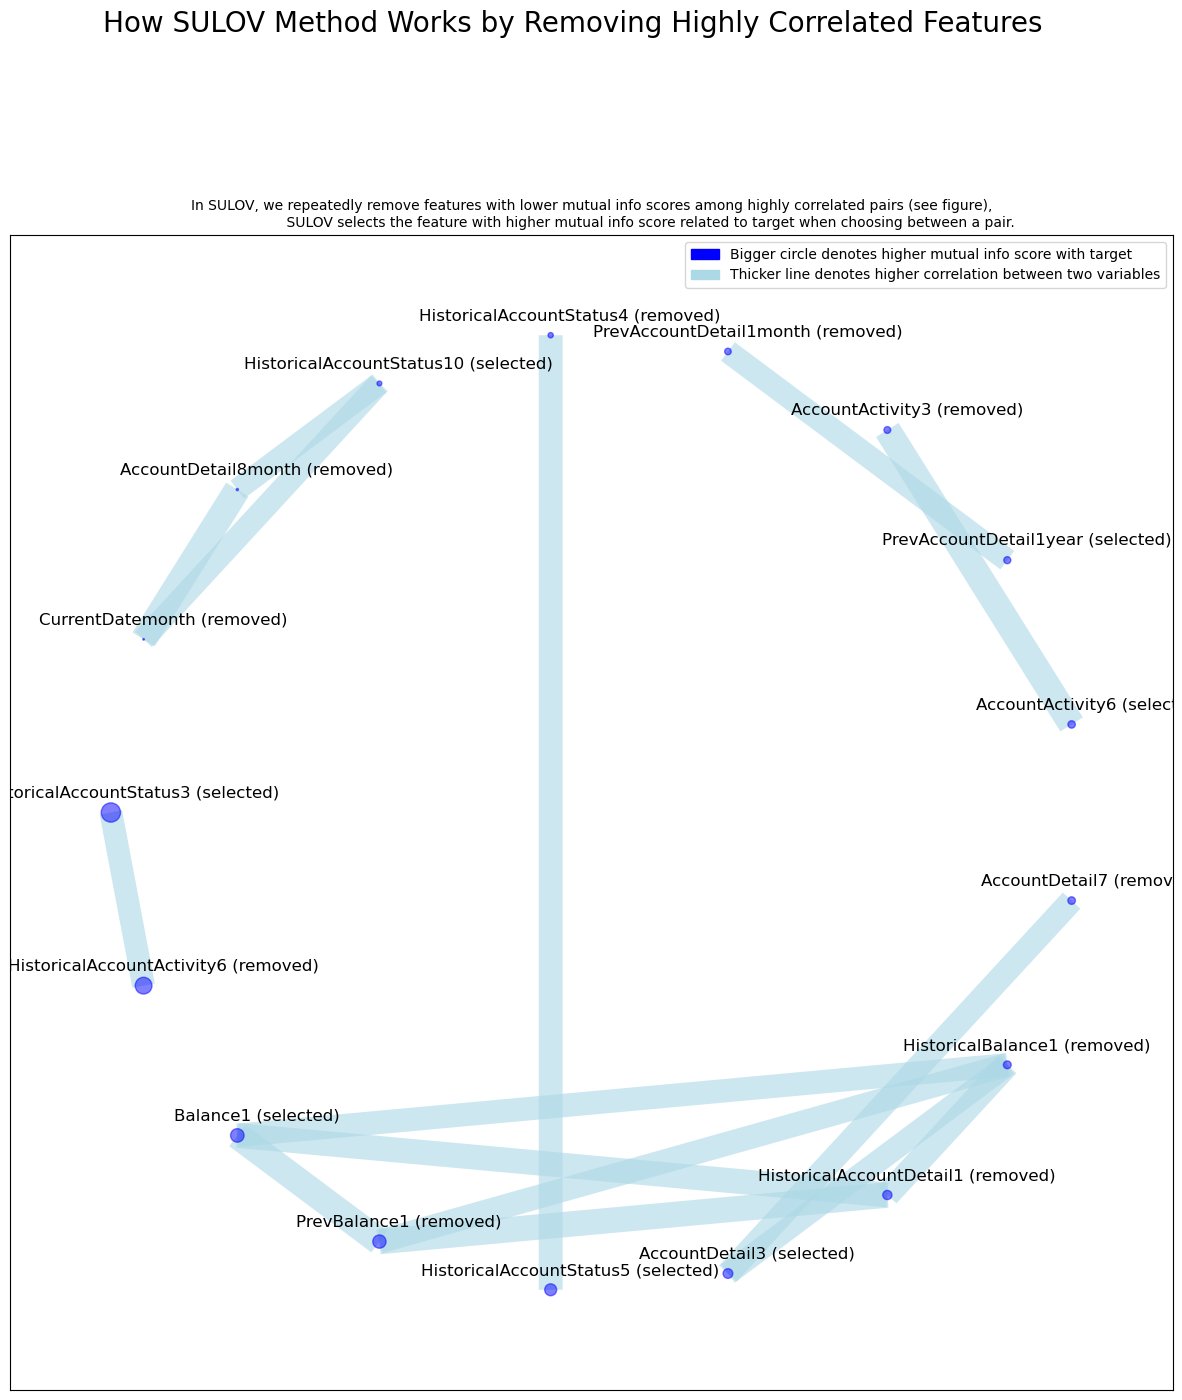

Time taken for SULOV method = 24 seconds
    Adding 0 categorical variables to reduced numeric variables  of 50
Finally 50 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 50 
    Taking top 9 features per iteration...
    XGBoost version using 1.7.1 as tree method: hist
Number of booster rounds = 20
        using 50 variables...
            selecting 23 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 40 variables...
            selecting 18 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
 

In [8]:
train, test = featurewiz(train, target, corr_limit=0.8, verbose=1, sep=",",
header=0,test_data=test, feature_engg="", category_encoders="")

In [29]:
X=train.drop(['Target'],axis=1)
y=train['Target']
y_valid, gbm_val_probs, gbm_test_preds, gini=[],[],[],[]
ft_importance=pd.DataFrame(index=X.columns)
sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):
    
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(
        X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    params = {'boosting_type': 'gbdt',
              'n_estimators': 1000,
              'num_leaves': 50,
              'learning_rate': 0.05,
              'colsample_bytree': 0.9,
              'min_child_samples': 2000,
              'max_bins': 500,
              'reg_alpha': 2,
              'objective': 'binary',
              'random_state': 21}
    
    gbm = LGBMClassifier(**params).fit(X_train, y_train, 
                                       eval_set=[(X_train, y_train), (X_val, y_val)],
                                       callbacks=[early_stopping(200), log_evaluation(500)],
                                       eval_metric=['auc','binary_logloss'])
    gbm_prob = gbm.predict_proba(X_val)[:,1]
    gbm_val_probs.append(gbm_prob)
    y_valid.append(y_val)
    
    y_pred=pd.DataFrame(data={'prediction':gbm_prob})
    y_true=pd.DataFrame(data={'target':y_val.reset_index(drop=True)})
    
    auc_score=roc_auc_score(y_val, gbm_prob)
    gbm_test_preds.append(gbm.predict_proba(test)[:,1])    
    ft_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_    
    print("AUC: {:.4f}".format(auc_score))
    
    del X_train, y_train, X_val, y_val
    _ = gc.collect()
    
del X, y
plot_roc(y_valid, gbm_val_probs)


Fold 1
Train shape: (270000, 63), (270000,), Valid shape: (30000, 63), (30000,)

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.849139	training's binary_logloss: 0.473209	valid_1's auc: 0.829268	valid_1's binary_logloss: 0.494337
Early stopping, best iteration is:
[792]	training's auc: 0.857884	training's binary_logloss: 0.462512	valid_1's auc: 0.829733	valid_1's binary_logloss: 0.493927
AUC: 0.8297

Fold 2
Train shape: (270000, 63), (270000,), Valid shape: (30000, 63), (30000,)

Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.849309	training's binary_logloss: 0.472695	valid_1's auc: 0.827565	valid_1's binary_logloss: 0.49911
[1000]	training's auc: 0.863313	training's binary_logloss: 0.455479	valid_1's auc: 0.828584	valid_1's binary_logloss: 0.49797
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.863313	training's binary_logloss: 0.455479	valid_1's auc: 0.828584	valid_1's binary_loglo

In [30]:
np.mean(gbm_test_preds, axis=0)

array([0.11852542, 0.17797962, 0.03636781, ..., 0.49386732, 0.47314402,
       0.55544866])

In [31]:
test['Prediction']=np.mean(gbm_test_preds, axis=0)

odf=pd.DataFrame(data={'Target':test['Prediction'].apply(lambda x: 1 if x>0.5 else 0)})
odf=odf.Target.value_counts(normalize=True)
odf.rename(index={1:'Default',0:'Not Default'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=odf.index, values=odf*100, hole=.45, 
                     showlegend=True,sort=False, 
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Payment: %{value:.2f}%<extra></extra>"))
fig.update_layout(title='Predicted Target Distribution', 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

In [32]:
final_df = pd.read_csv('/Users/naveenmsu/Desktop/Competition/DSU Competition Out-Of-Time Data.csv')
output = final_df[['UniqueID','CurrentDate']]
output['Prediction'] = test['Prediction'].copy()

In [33]:
#output.to_csv('TabWeau.csv', index=False)
output.head()

UniqueID CurrentDate  Prediction
0  32958481   11/1/2018    0.118525
1  33899630   11/1/2018    0.177980
2  28273111   11/1/2018    0.036368
3  34486080   11/1/2018    0.571529
4  31963197   11/1/2018    0.482933